# <span style="color:#0b486b">  FIT3181: Deep Learning (2022)</span>
***
*CE/Lecturer (Clayton):*  **Dr Trung Le** | trunglm@monash.edu <br/>
*Lecturer (Malaysia):*  **Dr Lim Chern Hong** | lim.chernhong@monash.edu <br/>  <br/>
*Tutor:*  **Mr Thanh Nguyen** \[Thanh.Nguyen4@monash.edu \] |**Mr Tuan Nguyen**  \[tuan.ng@monash.edu \] |**Mr Anh Bui** \[tuananh.bui@monash.edu\] | **Dr Binh Nguyen** \[binh.nguyen1@monash.edu \] | **Mr Md Mohaimenuzzaman** \[md.mohaimen@monash.edu \] |**Mr James Tong** \[james.tong1@monash.edu \]
<br/> <br/>
Faculty of Information Technology, Monash University, Australia
***on Technology, Monash University, Australia
******

# <span style="color:#0b486b">Tutorial 06a: Tricks of The Trade with TF 2.x</span><span style="color:red;  font-size: 18px">***** (highly important)</span> #

**The purpose of this tutorial is to demonstrate the important practical aspects of deep learning with TF 2.x. The following topics are presented:**
1. How to apply weight initialization, batch normalization, and dropout to regularize deep networks and stabilize a training process.
2. How to customize the loss function, weight initializer, and metric of interest for your models.
3. How to do learning rate scheduler.
4. How to monitor the training process to spot out and identify underfitting and overfitting and how to apply early stopping.
5. How to reuse a pre-trained model and further do fine-tuning.

***Acknowledgement***: *some content in this tutorial was developed based on the Chapter 12 materials from the book `Hands-on Machine Learning with Scikit-learn and Tensorflow`.*

---

## <span style="color:#0b486b">1. Download and prepare data</span> ##

We first import the necessary packages and modules for this tutorial. Note that we import TF 2.x and keras which now becomes a part of TF 2.x.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, models, layers
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import os
import numpy as np
%matplotlib inline
np.random.seed(123)
tf.random.set_seed(123)

We use dataset Cifar10 in this tutorial. Let's download and preprocess it by normalizing. 

In [2]:
(X_train, y_train) , (X_test, y_test) = datasets.cifar10.load_data()
X_train, X_test = X_train/255.0, X_test/255.0
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000,)
(10000, 32, 32, 3) (10000,)


To speed up the training, we create the subsets of training and validation sets including 5,000 and 5,000 images respectively. When you run this tutorial on a stronger machine with GPU, you can try the entire dataset. 

In [3]:
idxs = np.arange(X_train.shape[0])
np.random.shuffle(idxs)
X_train = X_train[idxs]
y_train = y_train[idxs]

In [4]:
n_train, n_valid = 5000, 5000 
X_train, X_valid = X_train[:n_train], X_train[n_train:n_train+n_valid]
y_train, y_valid = y_train[:n_train], y_train[n_train:n_train+n_valid]
print('Training set', X_train.shape, y_train.shape)
print('Validation set', X_valid.shape, y_valid.shape)

Training set (5000, 32, 32, 3) (5000,)
Validation set (5000, 32, 32, 3) (5000,)


## <span style="color:#0b486b">2. Define a custom activation function, loss function, and metric</span>

### <span style="color:#0b486b">2.1. Define a custom activation function</span>

#### <span style="color:#0b486b">2.1.1. Sigmoid activation function</span>

We define the *sigmoid activation function* as a TensorFlow function.

In [5]:
def sigmoid(z):
    return 1 / (1 + tf.math.exp(-z))

We now plot the sigmoid activation function.

In [6]:
z = np.linspace(-5, 5, 200)
plt.plot(z, sigmoid(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k--')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-5, 5], 'k-')
plt.grid(True)
plt.title(r"Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.1, 1.1])
plt.show()

Plot the gradient of the sigmoid.

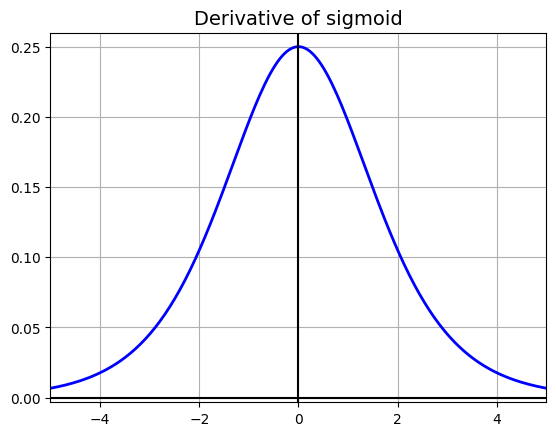

In [7]:
z = np.linspace(-5, 5, 200)
with tf.GradientTape(persistent=True) as g:
    x = tf.Variable(z)
    y = sigmoid(x)
grads = g.gradient(y,x)
plt.plot(z, grads.numpy(), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-5, 5], 'k-')
plt.grid(True)
plt.title(r"Derivative of sigmoid", fontsize=14)
plt.axis([-5, 5, min(grads.numpy())- 1E-2, max(grads.numpy())+ 1E-2])
plt.show()

#### <span style="color:#0b486b">2.1.2. Tanh activation function</span>

We define the *tanh* activation function.

In [8]:
def tanh(z):
    return ((1-tf.math.exp(-2*z)) / (1 + tf.math.exp(-2*z)))

We plot the *tanh* activation function.

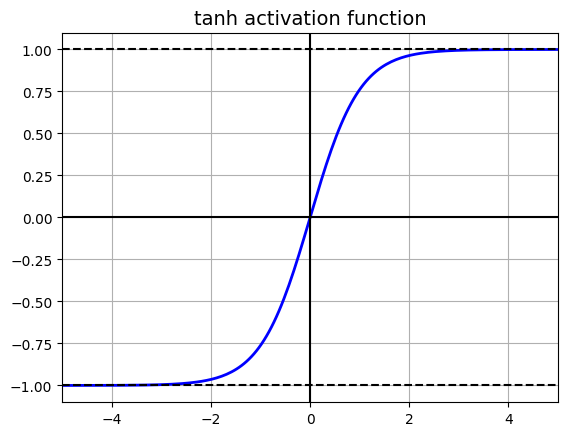

In [9]:
z = np.linspace(-5, 5, 200)
plt.plot(z, tanh(z), "b-", linewidth=2)
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-5, 5], 'k-')
plt.grid(True)
plt.title(r"tanh activation function", fontsize=14)
plt.axis([-5, 5, -1.1, 1.1])
plt.show()

We plot the *gradient* of tanh activation function.

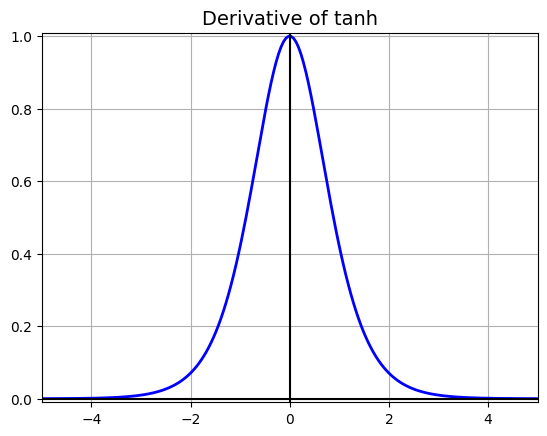

In [10]:
z = np.linspace(-5, 5, 200)
with tf.GradientTape(persistent=True) as g:
    x = tf.Variable(z)
    y = tanh(x)
grads = g.gradient(y,x)
plt.plot(z, grads.numpy(), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-5, 5], 'k-')
plt.grid(True)
plt.title(r"Derivative of tanh", fontsize=14)
plt.axis([-5, 5, min(grads.numpy())- 1E-2, max(grads.numpy()) + 1E-2])
plt.show()

#### <span style="color:#0b486b">2.1.3. Exponential linear unit (ELU) activation function</span>

We define the *ELU activation function* as a TensorFlow function.

In [11]:
def elu(z, alpha=1):
    return tf.where(z < 0, alpha * (tf.math.exp(z) - 1), z)

We plot the ELU activation function as bellows.

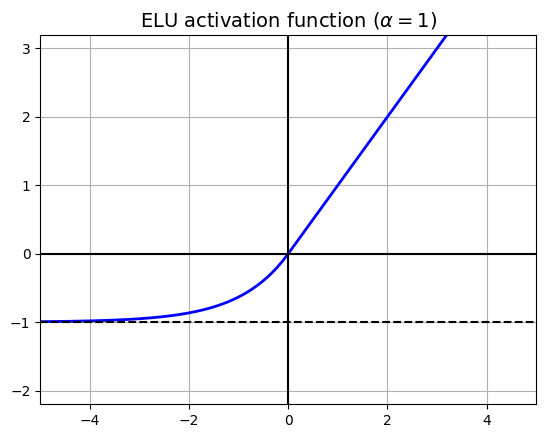

In [12]:
z = np.linspace(-5, 5, 200)
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-5, 5], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])
plt.show()

We plot the *gradient* of ELU activation function.

In [13]:
z = np.linspace(-5, 5, 200)
with tf.GradientTape(persistent=True) as g:
    x = tf.Variable(z)
    y = elu(x)
grads = g.gradient(y,x)
plt.plot(z, grads.numpy(), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-5, 5], 'k-')
plt.grid(True)
plt.title(r"Derivative of ELU", fontsize=14)
plt.axis([-5, 5, min(grads.numpy())- 1E-2, max(grads.numpy()) + 1E-2])
plt.show()

#### <span style="color:#0b486b">2.1.4. ReLU (ReLU) activation function</span>

We define the *ReLU* activation function.

In [14]:
def relu(z):
    return tf.maximum(0.0, z)

We plot the *ReLU* activation function.

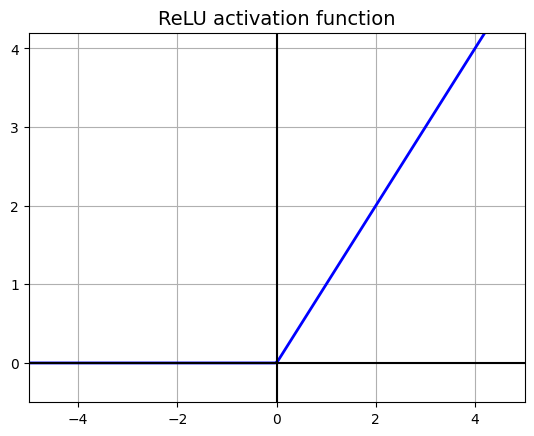

In [15]:
z = np.linspace(-5, 5, 200)
plt.plot(z, relu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-5, 5], 'k-')
plt.grid(True)
plt.title("ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])
plt.show()
plt.show()

We plot the *gradient* of ReLU activation function.

In [16]:
z = np.linspace(-5, 5, 200)
with tf.GradientTape(persistent=True) as g:
    x = tf.Variable(z)
    y = relu(x)
grads = g.gradient(y,x)
plt.plot(z, grads.numpy(), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-5, 5], 'k-')
plt.grid(True)
plt.title(r"Derivative of ReLU", fontsize=14)
plt.axis([-5, 5, min(grads.numpy())- 1E-2, max(grads.numpy()) + 1E-2])
plt.show()

#### <span style="color:#0b486b">2.1.5. Leaky ReLU (LeakyReLU) activation function</span>

We need to define the LeakyReLU activation function as a TF function.

In [17]:
def leaky_relu(z, alpha=0.01):
    return tf.maximum(alpha*z, z)

We now plot the LeakyReLU activation function as a TF function.

In [18]:
z = np.linspace(-5, 5, 200)
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-5, 5], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])
plt.show()

We plot the *gradient* of LeakyReLU activation function.

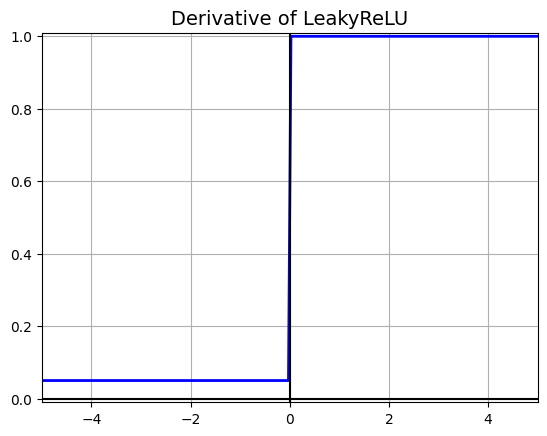

In [19]:
z = np.linspace(-5, 5, 200)
with tf.GradientTape(persistent=True) as g:
    x = tf.Variable(z)
    y = leaky_relu(x, 0.05)
grads = g.gradient(y,x)
plt.plot(z, grads.numpy(), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-5, 5], 'k-')
plt.grid(True)
plt.title(r"Derivative of LeakyReLU", fontsize=14)
plt.axis([-5, 5, min(0, min(grads.numpy())) - 1E-2, max(grads.numpy()) + 1E-2])
plt.show()

#### <span style="color:#0b486b">2.1.6. SeLU  activation function (SeLU)</span>

We define the *SeLU* activation function.

In [20]:
from scipy.special import erfc
# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 
            + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [21]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * tf.where(z < 0, alpha * (tf.exp(z) - 1), z)

We plot this activation function.

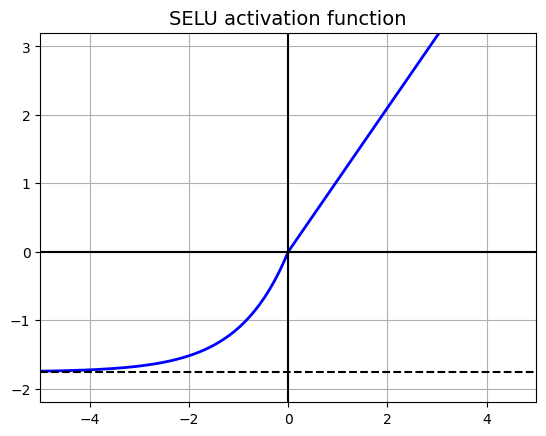

In [22]:
z = np.linspace(-5, 5, 200)
plt.plot(z, selu(z, scale=scale_0_1, alpha=alpha_0_1), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-5, 5], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])
plt.show()

We plot its gradient.

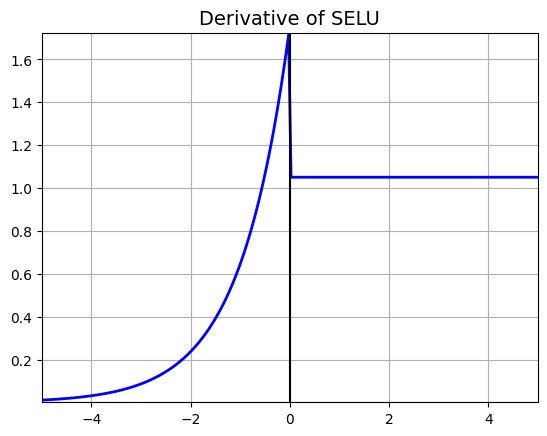

In [23]:
z = np.linspace(-5, 5, 200)
with tf.GradientTape(persistent=True) as g:
    x = tf.Variable(z)
    y = selu(x)
grads = g.gradient(y,x)
plt.plot(z, grads.numpy(), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-5, 5], 'k-')
plt.grid(True)
plt.title(r"Derivative of SELU", fontsize=14)
plt.axis([-5, 5, min(grads.numpy())- 1E-2, max(grads.numpy()) + 1E-2])
plt.show()

##### <span style="color:#0b486b">2.2. Define a custom loss function</span>

You can define and customize your own loss function. In this example, we simply redefine the cross-entropy loss function. Note that to this end, we declare the class *my_CE_loss* which is inherited from the *keras.losses.Loss* class. All we need now are to override the method or function *call*. In particular, in this function, we have two important parameters: *y_true* and *y_pred*.
- *y_true*: 1D tensor of true labels for the current mini-batch.
- *y_pred*: 2D tensor of predicted probabilities with the shape of $batch\_size \times num\_classes$.

In addition, the *call* function has to return the 1D tensor of losses for the data examples in the current batch. You can refer to [this link](https://keras.io/api/losses/#creating-custom-losses) for more information regarding the existing loss function supported by Keras Tensorflow. 

In what follows, we implement the `sparse_crossentropy_loss` in three different ways. The first version (`my_CE_loss_1`) simply reuses the built-in loss of TF keras, while the second (`my_CE_loss_2`) and third (`my_CE_loss_3`) versions are more complicated and require us to manipulate the tensors of `y_true` and `y_pred`.
- If you want to print out the values to inspect insightfully three versions, you can inject `tf.print(tensor)` to print out the tensor values.

In [24]:
class my_CE_loss_1(tf.keras.losses.Loss):
    def __init__(self):
        super(my_CE_loss_1, self).__init__()
        
    def call(self, y_true, y_pred):
        loss =  tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits= False))
        return loss

In [25]:
class my_CE_loss_2(tf.keras.losses.Loss):
    def __init__(self, eps=1E-10, num_classes= 10):
        super(my_CE_loss_2, self).__init__()
        self.eps = eps
        self.num_classes = num_classes
        
    def call(self, y_true, y_pred):
        idxs = tf.stack([tf.range(tf.shape(y_pred)[0]), tf.cast(tf.squeeze(y_true), tf.int32)], axis=0)
         #use tf.print(idxs) here in case you want to print out values
        y_pred_slice = tf.gather_nd(y_pred, tf.transpose(idxs))
        loss = -tf.math.log(y_pred_slice + self.eps) 
        loss = tf.reduce_mean(loss)
        return loss

In [26]:
class my_CE_loss_3(tf.keras.losses.Loss):
    def __init__(self, eps=1E-10, num_classes= 10):
        super(my_CE_loss_3, self).__init__()
        self.eps = eps
        self.num_classes = num_classes
        
    def call(self, y_true, y_pred):
        y_true_1_hot = tf.one_hot(tf.transpose(tf.cast(y_true, tf.int32), perm= [1,0])[0], depth= self.num_classes, axis=-1)
        #use tf.print(y_true_1_hot) here in case you want to print out values
        loss = -tf.math.multiply(y_true_1_hot, tf.math.log(y_pred + self.eps))
        loss = tf.reduce_mean(loss)
        return loss

### <span style="color:#0b486b">2.3. Define a custom weight initializer and regularizer</span>

In what follows, we write the code for our own Xavier and He initializations as a demonstration of how to implement our own weight initialization strategy. Similarly, you can custom l1 and l2 or your own regularizers with appropriate inputs and outputs. Please refer to [this link](https://keras.io/api/layers/initializers/) for more information regarding the initialization strategies supported by Keras Tensorflow.

In [27]:
def my_Xavier_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

In [28]:
import math
def my_He_initializer(shape, alpha=math.sqrt(2), dtype=tf.float32):
    stddev = alpha*tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

In [29]:
def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

In [30]:
def my_l2_regularizer(weights):
    return tf.reduce_sum(0.01 * tf.square(weights))

### <span style="color:#0b486b">2.4. Define a custom metric</span>

In addition to the existing metrics supported by Keras Tensorflow as in [this link](https://keras.io/api/metrics/), you can define your own metric of interest that fits your own purpose. Basically, you need to inherit from the class *tf.keras.metrics.Metric* and override the functions or methods: *\__init\__*, *update_state*, and *result*.

Here we are going to implement the *top_k_accuracy* which returns a correct prediction if the top k predicted labels include the true label.

In [31]:
class TopkAcc(tf.keras.metrics.Metric):
    def __init__(self, k=5, **kwargs):
        super().__init__(**kwargs) # handles base args (e.g., dtype)
        self.k = k
        self.total = self.add_weight("total", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.int32)
        y_true = tf.reshape(y_true, shape= [-1])
        b_array = tf.math.in_top_k(y_true, y_pred, self.k)
        num_corrects = tf.reduce_sum(tf.cast(b_array, tf.float32)) 
        self.total.assign_add(tf.reduce_sum(num_corrects))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))
        
    def result(self):
        return self.total / self.count

## <span style="color:#0b486b">3. Create our MiniVGG network</span> ##

We now create our MiniVGG network which applies the batch-norm, dropout techniques for mitigating the overfitting issue. We can also choose an initialization strategy for the weight matrices and biases.

In [32]:
def create_vgg_model(n_classes=10):
    vgg_model = models.Sequential()
    
    # # Other initialization strategies and different ways of passing parameters
    # Conv2D(..., activation='elu', kernel_initializer='glorot_uniform', ...)
    # Conv2D(..., activation=relu, kernel_initializer=my_He_initializer, ...)
    # Dense(..., activation=tf.nn.selu, kernel_initializer=tf.keras.initializers.lecun_normal(), ...)
    
    vgg_model.add(layers.Conv2D(32, (3,3), padding='same', activation=relu, kernel_initializer=my_Xavier_initializer, input_shape=(32,32,3)))
    vgg_model.add(layers.BatchNormalization(momentum=0.9))
    vgg_model.add(layers.Conv2D(32, (3,3), padding='same', activation=relu, kernel_initializer=my_Xavier_initializer))
    vgg_model.add(layers.BatchNormalization(momentum=0.9))
    vgg_model.add(layers.MaxPool2D(pool_size=(2,2))) # downscale the image size by 2
    vgg_model.add(layers.Dropout(rate=0.25)) # deactivate 25% of neurons for each feed-forward
    vgg_model.add(layers.Conv2D(64, (3,3), padding='same', activation=relu, kernel_initializer=my_Xavier_initializer))
    vgg_model.add(layers.BatchNormalization(momentum=0.9))
    vgg_model.add(layers.Conv2D(64, (3,3), padding='same', activation=relu, kernel_initializer=my_Xavier_initializer))
    vgg_model.add(layers.BatchNormalization(momentum=0.9))
    vgg_model.add(layers.MaxPool2D(pool_size=(2,2))) # downscale the image size by 2
    vgg_model.add(layers.Dropout(rate=0.25)) # deactivate 25% of neurons for each feed-forward
    vgg_model.add(layers.Flatten())
    vgg_model.add(layers.Dense(512, activation=relu, kernel_initializer=my_Xavier_initializer))
    vgg_model.add(layers.BatchNormalization(momentum=0.9))
    vgg_model.add(layers.Dropout(rate=0.5)) 
    vgg_model.add(layers.Dense(n_classes, activation='softmax')) # ten classes in Cifar10
    return vgg_model

Here is the architecture of our MiniVGG network. Note that in the declaration of the *compile* method, we monitor two metrics of interest: *accuracy* and *TopkAcc* with $k=5$.

In [33]:
vgg_model = create_vgg_model(10)
vgg_model.summary()
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
vgg_model.compile(optimizer=opt, loss=my_CE_loss_3(), metrics=[tf.keras.metrics.SparseCategoricalAccuracy(), TopkAcc(k=5)])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                        

In [34]:
vgg_model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=32, epochs=5)

Epoch 1/5
157/157 [==============================] - 16s 93ms/step - loss: 0.2363 - sparse_categorical_accuracy: 0.2892 - topk_acc: 0.7946 - val_loss: 0.2148 - val_sparse_categorical_accuracy: 0.3860 - val_topk_acc: 0.8674
Epoch 2/5
157/157 [==============================] - 14s 91ms/step - loss: 0.2407 - sparse_categorical_accuracy: 0.3156 - topk_acc: 0.8192 - val_loss: 0.1787 - val_sparse_categorical_accuracy: 0.3620 - val_topk_acc: 0.8868
Epoch 3/5
157/157 [==============================] - 15s 92ms/step - loss: 0.1939 - sparse_categorical_accuracy: 0.3700 - topk_acc: 0.8600 - val_loss: 0.1631 - val_sparse_categorical_accuracy: 0.4106 - val_topk_acc: 0.9046
Epoch 4/5
157/157 [==============================] - 14s 92ms/step - loss: 0.1626 - sparse_categorical_accuracy: 0.4316 - topk_acc: 0.9044 - val_loss: 0.1442 - val_sparse_categorical_accuracy: 0.5008 - val_topk_acc: 0.9270
Epoch 5/5
157/157 [==============================] - 14s 90ms/step - loss: 0.1429 - sparse_categorical_accur

## <span style="color:#0b486b">4. Learning Rate Scheduler</span> ##

Scheduling learning rate is an important practical aspect of training deep learning models. Basically, we gradually drop the learning rate. When training a deep learning model, we do not aim to find global minimal points because this task is almost impossible due to the complexity of the loss surface. Instead, we decay the learning rate to reduce the oscillation in order to find the good-enough points with sufficiently small loss value (e.g., local minimum). If we set a high learning rate, your model would overshoot these points.

In the following code, we show how to implement a learning rate scheduler in TF 2.x. Our code of learning rate schedule is placed in the function **step_decay** which indicates the formula:
- $lr = 0.01 \times 0.25^{epoch/5}$, which decays along with training epochs. You can find other learning rate schedule strategies here: [learning rate schedule strategies](https://d2l.ai/chapter_optimization/lr-scheduler.html) for your own implementation.

Below shows the code for the learning rate schedule based on the current epoch and learning rate.

In [35]:
def step_decay(epoch, learning_rate):
    # initialize the base initial learning rate, drop factor, and epochs to drop every
    init_lr = 0.01
    factor = 0.25
    drop_every = 5
    # compute learning rate for the current epoch
    learning_rate = init_lr*(factor ** (np.floor(epoch) / drop_every))
    return learning_rate

We now declare a callback for our **step_decay(epoch, learning_rate)** which helps us to rectify the learning rate during the training procedure.

In [36]:
lr_scheduler = keras.callbacks.LearningRateScheduler(step_decay)
my_vgg = create_vgg_model(n_classes=10) # create the model
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
my_vgg.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = my_vgg.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=32, epochs=20, callbacks=[lr_scheduler], verbose=1)

Epoch 1/20
157/157 [==============================] - 16s 94ms/step - loss: 2.3466 - accuracy: 0.2988 - val_loss: 5.4080 - val_accuracy: 0.3486 - lr: 0.0100
Epoch 2/20
157/157 [==============================] - 14s 90ms/step - loss: 1.7371 - accuracy: 0.4010 - val_loss: 1.7172 - val_accuracy: 0.4276 - lr: 0.0076
Epoch 3/20
157/157 [==============================] - 14s 90ms/step - loss: 1.4234 - accuracy: 0.4864 - val_loss: 1.7952 - val_accuracy: 0.4646 - lr: 0.0057
Epoch 4/20
157/157 [==============================] - 14s 92ms/step - loss: 1.2880 - accuracy: 0.5380 - val_loss: 1.6093 - val_accuracy: 0.4792 - lr: 0.0044
Epoch 5/20
157/157 [==============================] - 14s 90ms/step - loss: 1.1342 - accuracy: 0.5966 - val_loss: 1.4323 - val_accuracy: 0.5340 - lr: 0.0033
Epoch 6/20
157/157 [==============================] - 14s 90ms/step - loss: 1.0345 - accuracy: 0.6344 - val_loss: 1.3264 - val_accuracy: 0.5624 - lr: 0.0025
Epoch 7/20
157/157 [==============================] - 14s 

In what follows, we visualize the learning rate variation during the training process.

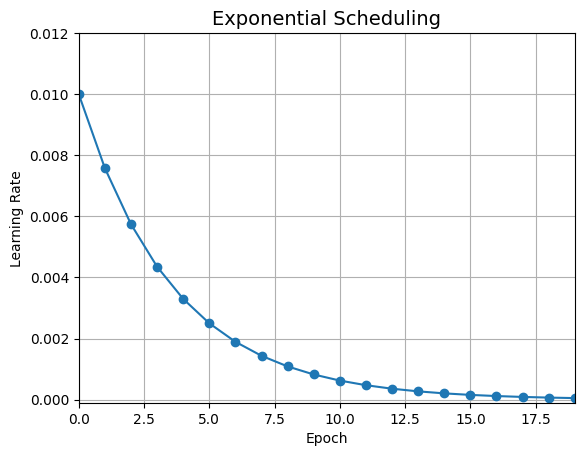

In [37]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, 20 - 1, -0.0001, 0.012])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

 **<span style="color:red">Exercise 1</span>:** Try with different learning rate schedulers as shown [here](https://d2l.ai/chapter_optimization/lr-scheduler.html).

## <span style="color:#0b486b">5. Spotting Underfitting/Overfitting and Early Stopping</span> ##

When training deep learning models, **observing and spotting underfitting/overfitting** are very important. At the very first epochs, because the model is not trained sufficiently, this suffers from **underfitting**, meaning that the existing model is too simple to characterize and fit the training data. However, when proceeding with the training procedure, the model becomes more complicated and fitting to the training dataset, hence possibly encountering **overfitting** at a certain point. 

We need to monitor the tendencies of training and validation losses to spot out the transmission of underfitting and overfitting for identifying a best-fit model.

<img src="./images/underfit_overfit.png" align="center" width=600/>

As shown in the above figure, we need to monitor and identify the epoch at which the validation loss starts increasing while the training loss is still decreasing. The model tends to transfer from underfitting to overfitting at this point, hence if we apply an **early stopping** here, we seem to reach the best-fit model.

In what follows, we inspect how to implement the code to monitor the training, validation losses and accuracies to spot out their tendencies. Our treatment includes:
- A json file to store the history of training.
- A figure file to store the plots of training, validation losses and accuracies.
- A model path to store the latest model

In [39]:
from tensorflow.keras.callbacks import BaseLogger
import json
import os
import pandas as pd
import copy

The following code supports us in saving a history H to a file. The history H is a dictionary of lists.
- H={'loss':[2.5, 2.44, 2.3, 2.1], 'accuracy': [0.3, 0.42, 0.51, 0.56], 'val_loss':[2.7, 2.54, 2.44, 2.15], 'val_accuracy': [0.28, 0.41, 0.53, 0.55]}.

In [40]:
def save_to_file(H=None, fig_path=None):
    fig = plt.subplots(1, 2, figsize=(15, 5))
    x = [i+1 for i in range(len(H["loss"]))] 
    plt.subplot(121)
    plt.plot(x, H["loss"], label="loss")
    plt.plot(x, H["val_loss"], label="val_loss")
    plt.grid()
    plt.legend()
    plt.title("Losses")

    plt.subplot(122)
    plt.plot(x, H["accuracy"], label="accuracy")
    plt.plot(x, H["val_accuracy"], label="val_accuracy")
    plt.grid()
    plt.legend()
    plt.title("Accuracies")
    
    plt.savefig(fig_path)
    plt.close()

We declare the class **TrainingMonitor** which inherits the class **keras.callbacks.BaseLogger**. The class **TrainingMonitor** has some attributes:
- *fig_path* specifies where to store the plot of losses and accuracies.
- *json_path* specifies where to store the history of losses and accuracies in the json format.
- *model_path* specifies where to store our model.
- *model* specifies the model object (i.e., an instance of our VGG model).

In the callback function **on_train_begin** (triggered once when the training is started), we read the history in our json file to self.H, while in the callback function **on_train_end** (triggered once when the training is ended), we store the trained model to a file.

In the callback function **on_epoch_end** (triggered at the end of each epoch), we take the information of the training/validation losses and accuracies via **logs** and then update the history self.H. Finally, we update the json file, and plot and save the plot of history to our figure file.

In [41]:
class TrainingMonitor(BaseLogger):
    def __init__(self, fig_path=None, json_path=None, model_path=None, model=None):
        super(TrainingMonitor, self).__init__()
        self.fig_path = fig_path
        self.json_path = json_path
        self.model_path = model_path
        self.model = model
        
    def on_train_begin(self, logs={}): # triggered when the training gets started
        self.H = {} # initialize the history dictionary
        if self.json_path is not None:   # if the JSON history path exists, load the training history
            if os.path.exists(self.json_path):
                self.H = json.loads(open(self.json_path).read())
    
    def on_train_end(self, logs={}): # triggered when the training gets ended
        if self.model_path != None:
            self.model.save_weights(self.model_path) # save the current model when finishing the training
            
        if len(self.H["loss"]) > 0:
            save_to_file(self.H, self.fig_path)
            
        if self.json_path is not None: # check to see if the training history should be serialized to file
            f = open(self.json_path, "w")
            f.write(json.dumps(self.H))
            f.close()
        
    def on_epoch_end(self, epoch, logs={}):
        for (k, v) in logs.items():   # loop over the logs and update the loss, accuracy, etc.
            self.H.setdefault(k, [])            
            self.H[k].append(str(round(v, 4)))

In [42]:
model_path = "./logs/section5/mini_vgg.h5"
fig_path = "./logs/section5/history.png"
json_path = "./logs/section5/history.json"

In the function **run_my_vgg**, we consider two cases:
- The model has been trained from scratch
  - We create a fresh new vgg model and use TraingMonitor to monitor the training.
- The model has been retrained
  - We load the existing model from the hard disk, train more, and use TraingMonitor to monitor the training.

In [43]:
def run_my_vgg(epochs=10):
    my_vgg = create_vgg_model(n_classes=10) # Create the model
    if os.path.exists(model_path):
        my_vgg.load_weights(model_path) # Restore the weights
        
    opt = keras.optimizers.Adam(learning_rate=0.001)
    my_vgg.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    monitor = TrainingMonitor(fig_path=fig_path, json_path=json_path, model_path=model_path, model=my_vgg)
    callbacks = [monitor]
    my_vgg.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=32, 
               epochs=epochs, callbacks=callbacks, verbose=1)

Here is the first time training.

In [44]:
run_my_vgg(epochs=10)

Epoch 1/10
157/157 [==============================] - 15s 92ms/step - loss: 2.3306 - accuracy: 0.3148 - val_loss: 1.9680 - val_accuracy: 0.4000
Epoch 2/10
157/157 [==============================] - 14s 92ms/step - loss: 1.7290 - accuracy: 0.4114 - val_loss: 1.7267 - val_accuracy: 0.4360
Epoch 3/10
157/157 [==============================] - 14s 91ms/step - loss: 1.5044 - accuracy: 0.4806 - val_loss: 1.6928 - val_accuracy: 0.4484
Epoch 4/10
157/157 [==============================] - 14s 91ms/step - loss: 1.3751 - accuracy: 0.5236 - val_loss: 1.7432 - val_accuracy: 0.4442
Epoch 5/10
157/157 [==============================] - 14s 90ms/step - loss: 1.2468 - accuracy: 0.5624 - val_loss: 1.6911 - val_accuracy: 0.4636
Epoch 6/10
157/157 [==============================] - 14s 91ms/step - loss: 1.1824 - accuracy: 0.5802 - val_loss: 1.8078 - val_accuracy: 0.4452
Epoch 7/10
157/157 [==============================] - 14s 92ms/step - loss: 1.1062 - accuracy: 0.6184 - val_loss: 1.6593 - val_accuracy:

Here is the figure after 10-epoch training. The gap between the loss values shows that the model has signs of overfitting

<img src="./images/history_10.png" align="center" width=800/>

Let us try the second-time training with 10 epochs more to see if the model can be further improved.

In [45]:
run_my_vgg(epochs=10)

Epoch 1/10
157/157 [==============================] - 16s 96ms/step - loss: 0.6305 - accuracy: 0.7782 - val_loss: 1.6577 - val_accuracy: 0.5160
Epoch 2/10
157/157 [==============================] - 14s 90ms/step - loss: 0.5803 - accuracy: 0.7986 - val_loss: 1.7066 - val_accuracy: 0.5234
Epoch 3/10
157/157 [==============================] - 14s 91ms/step - loss: 0.5055 - accuracy: 0.8212 - val_loss: 2.1450 - val_accuracy: 0.4928
Epoch 4/10
157/157 [==============================] - 14s 89ms/step - loss: 0.5105 - accuracy: 0.8220 - val_loss: 1.8377 - val_accuracy: 0.5222
Epoch 5/10
157/157 [==============================] - 14s 91ms/step - loss: 0.4530 - accuracy: 0.8432 - val_loss: 1.9062 - val_accuracy: 0.5260
Epoch 6/10
157/157 [==============================] - 14s 89ms/step - loss: 0.4105 - accuracy: 0.8584 - val_loss: 1.9776 - val_accuracy: 0.5316
Epoch 7/10
157/157 [==============================] - 14s 91ms/step - loss: 0.3574 - accuracy: 0.8806 - val_loss: 2.2556 - val_accuracy:

As shown in the following figure, the training becomes even worse with increasing validation loss and fluctuating validation accuracy.

<img src="./images/history_20.png" align="center" width=800/>

## <span style="color:#0b486b">6. Early Stopping</span> ##

We now demonstrate how to implement early stopping with TF 2.x. It is quite convenient with the built-in callback **EarlyStopping**. Here we set that we apply an early stopping if the validation loss is not decreasing two times in a row.

In [46]:
from tensorflow.keras.callbacks import EarlyStopping
early_checkpoint = EarlyStopping(patience=2, monitor='val_loss', mode='min')
callbacks = [early_checkpoint]
opt = keras.optimizers.Adam(learning_rate=0.001)
vgg_model = create_vgg_model()
vgg_model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
vgg_model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=32, epochs=20, callbacks=callbacks, verbose=1)

Epoch 1/20
157/157 [==============================] - 16s 94ms/step - loss: 2.3241 - accuracy: 0.3118 - val_loss: 2.1069 - val_accuracy: 0.3898
Epoch 2/20
157/157 [==============================] - 14s 91ms/step - loss: 1.7743 - accuracy: 0.4190 - val_loss: 1.7912 - val_accuracy: 0.4382
Epoch 3/20
157/157 [==============================] - 14s 91ms/step - loss: 1.4902 - accuracy: 0.4884 - val_loss: 1.8224 - val_accuracy: 0.4454
Epoch 4/20
157/157 [==============================] - 14s 91ms/step - loss: 1.3908 - accuracy: 0.5162 - val_loss: 1.5451 - val_accuracy: 0.4842
Epoch 5/20
157/157 [==============================] - 14s 90ms/step - loss: 1.2481 - accuracy: 0.5588 - val_loss: 1.5446 - val_accuracy: 0.4864
Epoch 6/20
157/157 [==============================] - 14s 88ms/step - loss: 1.1675 - accuracy: 0.5916 - val_loss: 1.6543 - val_accuracy: 0.4590
Epoch 7/20
157/157 [==============================] - 14s 88ms/step - loss: 1.0765 - accuracy: 0.6190 - val_loss: 1.5623 - val_accuracy:

The early stopping is undertaken to save up our training time.

## <span style="color:#0b486b">7. Checkpointing Neural Network Model Improvements</span> ##

We will be training the MiniVGGNet architecture on the CIFAR-10 dataset and then serializing our network weights to disk for the best models with either a **minimal validation loss** or **maximal validation accuracy**. 

In [47]:
vgg_model = create_vgg_model()
opt = keras.optimizers.SGD(learning_rate=0.01, decay=0.01/40, momentum=0.9, nesterov=True)
vgg_model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In the following code, we create two checkpoints:
- *val_loss_checkpoint* to store the best model with the lowest validation loss.
- *Val_acc_checkpoint* to store the best model with the highest validation accuracy.

In [48]:
val_loss_checkpoint = ModelCheckpoint(os.path.join("./ckpts", "best_val"), monitor="val_loss", mode="min", save_best_only=True, verbose=1)
val_acc_checkpoint = ModelCheckpoint(os.path.join("./ckpts", "best_acc"), monitor="val_accuracy", mode="max", save_best_only=True, verbose=1)
callbacks = [val_loss_checkpoint, val_acc_checkpoint]

In [49]:
H = vgg_model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=32, epochs=20, callbacks=callbacks, verbose=1)

Epoch 1/20
156/157 [============================>.] - ETA: 0s - loss: 2.3495 - accuracy: 0.3049
Epoch 1: val_loss improved from inf to 2.05202, saving model to ./ckpts\best_val


INFO:tensorflow:Assets written to: ./ckpts\best_val\assets


INFO:tensorflow:Assets written to: ./ckpts\best_val\assets



Epoch 1: val_accuracy improved from -inf to 0.34900, saving model to ./ckpts\best_acc


INFO:tensorflow:Assets written to: ./ckpts\best_acc\assets


INFO:tensorflow:Assets written to: ./ckpts\best_acc\assets


157/157 [==============================] - 19s 117ms/step - loss: 2.3512 - accuracy: 0.3050 - val_loss: 2.0520 - val_accuracy: 0.3490
Epoch 2/20
156/157 [============================>.] - ETA: 0s - loss: 1.8861 - accuracy: 0.3824
Epoch 2: val_loss improved from 2.05202 to 2.00086, saving model to ./ckpts\best_val


INFO:tensorflow:Assets written to: ./ckpts\best_val\assets


INFO:tensorflow:Assets written to: ./ckpts\best_val\assets



Epoch 2: val_accuracy improved from 0.34900 to 0.36440, saving model to ./ckpts\best_acc


INFO:tensorflow:Assets written to: ./ckpts\best_acc\assets


INFO:tensorflow:Assets written to: ./ckpts\best_acc\assets


157/157 [==============================] - 19s 124ms/step - loss: 1.8888 - accuracy: 0.3820 - val_loss: 2.0009 - val_accuracy: 0.3644
Epoch 3/20
156/157 [============================>.] - ETA: 0s - loss: 1.7141 - accuracy: 0.4243
Epoch 3: val_loss improved from 2.00086 to 1.91202, saving model to ./ckpts\best_val


INFO:tensorflow:Assets written to: ./ckpts\best_val\assets


INFO:tensorflow:Assets written to: ./ckpts\best_val\assets



Epoch 3: val_accuracy improved from 0.36440 to 0.39240, saving model to ./ckpts\best_acc


INFO:tensorflow:Assets written to: ./ckpts\best_acc\assets


INFO:tensorflow:Assets written to: ./ckpts\best_acc\assets


157/157 [==============================] - 19s 121ms/step - loss: 1.7147 - accuracy: 0.4238 - val_loss: 1.9120 - val_accuracy: 0.3924
Epoch 4/20
156/157 [============================>.] - ETA: 0s - loss: 1.6099 - accuracy: 0.4521
Epoch 4: val_loss did not improve from 1.91202

Epoch 4: val_accuracy did not improve from 0.39240
157/157 [==============================] - 15s 96ms/step - loss: 1.6093 - accuracy: 0.4524 - val_loss: 2.1553 - val_accuracy: 0.3664
Epoch 5/20
156/157 [============================>.] - ETA: 0s - loss: 1.4644 - accuracy: 0.4938
Epoch 5: val_loss did not improve from 1.91202

Epoch 5: val_accuracy did not improve from 0.39240
157/157 [==============================] - 16s 102ms/step - loss: 1.4660 - accuracy: 0.4940 - val_loss: 2.4769 - val_accuracy: 0.3136
Epoch 6/20
156/157 [============================>.] - ETA: 0s - loss: 1.4284 - accuracy: 0.5070
Epoch 6: val_loss did not improve from 1.91202

Epoch 6: val_accuracy did not improve from 0.39240
157/157 [=====

INFO:tensorflow:Assets written to: ./ckpts\best_acc\assets


INFO:tensorflow:Assets written to: ./ckpts\best_acc\assets


157/157 [==============================] - 19s 119ms/step - loss: 1.3441 - accuracy: 0.5320 - val_loss: 1.9356 - val_accuracy: 0.4184
Epoch 8/20
156/157 [============================>.] - ETA: 0s - loss: 1.2797 - accuracy: 0.5471
Epoch 8: val_loss did not improve from 1.91202

Epoch 8: val_accuracy did not improve from 0.41840
157/157 [==============================] - 16s 105ms/step - loss: 1.2818 - accuracy: 0.5468 - val_loss: 2.1783 - val_accuracy: 0.3738
Epoch 9/20
156/157 [============================>.] - ETA: 0s - loss: 1.2091 - accuracy: 0.5849
Epoch 9: val_loss did not improve from 1.91202

Epoch 9: val_accuracy did not improve from 0.41840
157/157 [==============================] - 16s 104ms/step - loss: 1.2109 - accuracy: 0.5844 - val_loss: 2.0351 - val_accuracy: 0.4184
Epoch 10/20
156/157 [============================>.] - ETA: 0s - loss: 1.1737 - accuracy: 0.5857
Epoch 10: val_loss improved from 1.91202 to 1.91076, saving model to ./ckpts\best_val


INFO:tensorflow:Assets written to: ./ckpts\best_val\assets


INFO:tensorflow:Assets written to: ./ckpts\best_val\assets



Epoch 10: val_accuracy improved from 0.41840 to 0.44760, saving model to ./ckpts\best_acc


INFO:tensorflow:Assets written to: ./ckpts\best_acc\assets


INFO:tensorflow:Assets written to: ./ckpts\best_acc\assets


157/157 [==============================] - 21s 131ms/step - loss: 1.1742 - accuracy: 0.5854 - val_loss: 1.9108 - val_accuracy: 0.4476
Epoch 11/20
156/157 [============================>.] - ETA: 0s - loss: 1.1239 - accuracy: 0.6102
Epoch 11: val_loss did not improve from 1.91076

Epoch 11: val_accuracy did not improve from 0.44760
157/157 [==============================] - 14s 91ms/step - loss: 1.1259 - accuracy: 0.6096 - val_loss: 2.3480 - val_accuracy: 0.4026
Epoch 12/20
156/157 [============================>.] - ETA: 0s - loss: 1.0743 - accuracy: 0.6174
Epoch 12: val_loss did not improve from 1.91076

Epoch 12: val_accuracy did not improve from 0.44760
157/157 [==============================] - 14s 91ms/step - loss: 1.0737 - accuracy: 0.6176 - val_loss: 2.1295 - val_accuracy: 0.4198
Epoch 13/20
156/157 [============================>.] - ETA: 0s - loss: 1.0302 - accuracy: 0.6376
Epoch 13: val_loss improved from 1.91076 to 1.80697, saving model to ./ckpts\best_val


INFO:tensorflow:Assets written to: ./ckpts\best_val\assets


INFO:tensorflow:Assets written to: ./ckpts\best_val\assets



Epoch 13: val_accuracy improved from 0.44760 to 0.48240, saving model to ./ckpts\best_acc


INFO:tensorflow:Assets written to: ./ckpts\best_acc\assets


INFO:tensorflow:Assets written to: ./ckpts\best_acc\assets


157/157 [==============================] - 19s 121ms/step - loss: 1.0298 - accuracy: 0.6378 - val_loss: 1.8070 - val_accuracy: 0.4824
Epoch 14/20
156/157 [============================>.] - ETA: 0s - loss: 1.0004 - accuracy: 0.6462
Epoch 14: val_loss did not improve from 1.80697

Epoch 14: val_accuracy did not improve from 0.48240
157/157 [==============================] - 14s 89ms/step - loss: 1.0001 - accuracy: 0.6464 - val_loss: 1.9022 - val_accuracy: 0.4700
Epoch 15/20
156/157 [============================>.] - ETA: 0s - loss: 0.9795 - accuracy: 0.6571
Epoch 15: val_loss did not improve from 1.80697

Epoch 15: val_accuracy did not improve from 0.48240
157/157 [==============================] - 14s 91ms/step - loss: 0.9806 - accuracy: 0.6564 - val_loss: 2.1878 - val_accuracy: 0.4478
Epoch 16/20
156/157 [============================>.] - ETA: 0s - loss: 0.9293 - accuracy: 0.6721
Epoch 16: val_loss improved from 1.80697 to 1.79685, saving model to ./ckpts\best_val


INFO:tensorflow:Assets written to: ./ckpts\best_val\assets


INFO:tensorflow:Assets written to: ./ckpts\best_val\assets



Epoch 16: val_accuracy improved from 0.48240 to 0.48660, saving model to ./ckpts\best_acc


INFO:tensorflow:Assets written to: ./ckpts\best_acc\assets


INFO:tensorflow:Assets written to: ./ckpts\best_acc\assets


157/157 [==============================] - 19s 121ms/step - loss: 0.9289 - accuracy: 0.6722 - val_loss: 1.7969 - val_accuracy: 0.4866
Epoch 17/20
156/157 [============================>.] - ETA: 0s - loss: 0.9040 - accuracy: 0.6769
Epoch 17: val_loss did not improve from 1.79685

Epoch 17: val_accuracy did not improve from 0.48660
157/157 [==============================] - 15s 95ms/step - loss: 0.9041 - accuracy: 0.6770 - val_loss: 1.8596 - val_accuracy: 0.4854
Epoch 18/20
156/157 [============================>.] - ETA: 0s - loss: 0.8681 - accuracy: 0.6959
Epoch 18: val_loss did not improve from 1.79685

Epoch 18: val_accuracy improved from 0.48660 to 0.51060, saving model to ./ckpts\best_acc


INFO:tensorflow:Assets written to: ./ckpts\best_acc\assets


INFO:tensorflow:Assets written to: ./ckpts\best_acc\assets


157/157 [==============================] - 17s 107ms/step - loss: 0.8684 - accuracy: 0.6958 - val_loss: 1.8064 - val_accuracy: 0.5106
Epoch 19/20
156/157 [============================>.] - ETA: 0s - loss: 0.8537 - accuracy: 0.7009
Epoch 19: val_loss did not improve from 1.79685

Epoch 19: val_accuracy did not improve from 0.51060
157/157 [==============================] - 14s 91ms/step - loss: 0.8536 - accuracy: 0.7012 - val_loss: 2.0484 - val_accuracy: 0.4760
Epoch 20/20
156/157 [============================>.] - ETA: 0s - loss: 0.8439 - accuracy: 0.7047
Epoch 20: val_loss did not improve from 1.79685

Epoch 20: val_accuracy did not improve from 0.51060
157/157 [==============================] - 14s 91ms/step - loss: 0.8433 - accuracy: 0.7050 - val_loss: 1.9802 - val_accuracy: 0.4968


We now load two best models from hard disk and then use them to evaluate the testing set.

In [50]:
from tensorflow.keras.models import load_model
best_acc_model = load_model('./ckpts/best_acc')
best_acc_model.compile(optimizer="sgd", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
best_acc_model.evaluate(X_test,y_test)

313/313 [==============================] - 5s 14ms/step - loss: 1.7809 - accuracy: 0.5080


[1.7809040546417236, 0.5080000162124634]

In [51]:
best_val_model = load_model('./ckpts/best_val')
best_val_model.compile(optimizer="sgd", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
best_val_model.evaluate(X_test,y_test)

313/313 [==============================] - 5s 14ms/step - loss: 1.7820 - accuracy: 0.4845


[1.7820243835449219, 0.484499990940094]

## <span style="color:#0b486b">8. Observing training progress using TensorBoard</span> ##

Before we start this part which shows you how to use TensorBoard to diagnose your training behaviours: gradient vanishing and exploding. We recommend you install the following extensions to facilitate working with TensorBoard in jupyter notebook or lab:

(1) TensorBoard extension for jupyter notebook: https://pypi.org/project/jupyter-tensorboard/

(2) TensorBoard extension for jupyter lab: https://github.com/chaoleili/jupyterlab_tensorboard

Using TensorBoard in TF 2.x to monitor and visualize the training progress is very convenient. Basically, we declare a callback for TensorBoard as *tf.keras.callbacks.TensorBoard* with the following parameters.

<img src="./images/tensorboard.png" align="center" width=700/>

In [52]:
vgg_model = create_vgg_model(10)
vgg_model.summary()
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
vgg_model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy', TopkAcc(k=5)])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_30 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_25 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_31 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                      

In [53]:
import time
import os
log_dir = os.path.join('./logs/section8/tensorboard', 'logs_' + time.strftime('%Y-%m-%d_%H.%M.%S'))
os.makedirs(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, write_graph=True, histogram_freq=1, update_freq='epoch', write_images=True, profile_batch = 50)

In [54]:
vgg_model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_valid, y_valid), callbacks=[tensorboard_callback])

Epoch 1/5
79/79 [==============================] - 16s 188ms/step - loss: 2.2537 - accuracy: 0.3144 - topk_acc_1: 0.8134 - val_loss: 2.1016 - val_accuracy: 0.3396 - val_topk_acc_1: 0.8546
Epoch 2/5
79/79 [==============================] - 14s 172ms/step - loss: 1.7065 - accuracy: 0.4058 - topk_acc_1: 0.8986 - val_loss: 1.9422 - val_accuracy: 0.4076 - val_topk_acc_1: 0.8958
Epoch 3/5
79/79 [==============================] - 14s 174ms/step - loss: 1.4637 - accuracy: 0.4798 - topk_acc_1: 0.9286 - val_loss: 1.6295 - val_accuracy: 0.4688 - val_topk_acc_1: 0.9138
Epoch 4/5
79/79 [==============================] - 14s 173ms/step - loss: 1.2821 - accuracy: 0.5492 - topk_acc_1: 0.9406 - val_loss: 1.3787 - val_accuracy: 0.5570 - val_topk_acc_1: 0.9448
Epoch 5/5
79/79 [==============================] - 14s 174ms/step - loss: 1.1343 - accuracy: 0.5964 - topk_acc_1: 0.9586 - val_loss: 1.5463 - val_accuracy: 0.5072 - val_topk_acc_1: 0.9352


If you want to visualize the gradients using TensorBoard, you can use the following code.

In [58]:
import numpy as np
class GradientLogTensorBoard(tf.keras.callbacks.TensorBoard):
    def __init__(self, log_dir='logs', histogram_freq=1, write_graph=False, write_images=False, update_freq='epoch', profile_batch=100000000, embeddings_freq=0, embeddings_metadata=None, num_instance= 100):
        super(GradientLogTensorBoard, self).__init__(log_dir, histogram_freq, write_graph, write_images, update_freq, profile_batch, embeddings_freq, embeddings_metadata)
        self.log_dir = log_dir
        self.histogram_freq = histogram_freq
        self.write_graph = write_graph
        self.write_images= write_images
        self.update_freq = update_freq
        self.profile_batch = profile_batch
        self.embeddings_freq = embeddings_freq
        self.embeddings_metadata = embeddings_metadata
        self.num_instance = num_instance
    
    def log_gradient(self, epoch):
        idxs = np.random.choice(X_train.shape[0], self.num_instance, replace= False)
        X_batch = X_train[idxs]
        y_batch = y_train[idxs]
        
        writer = self._train_writer
        # writer = self._get_writer(self._train_run_name)
        # writer = tf.summary.create_file_writer(self.log_dir)
        with writer.as_default(), tf.GradientTape() as g:
            g.watch(tf.convert_to_tensor(X_batch, dtype=tf.float64))
            _y_pred = self.model(X_batch)  # forward-propagation
            loss = tf.losses.sparse_categorical_crossentropy(y_batch, _y_pred)  # calculate loss
            gradients = g.gradient(loss, self.model.trainable_weights)  # back-propagation

            # In eager mode, grads does not have name, so we get names from model.trainable_weights
            for weights, grads in zip(self.model.trainable_weights, gradients):
                tf.summary.histogram(weights.name.replace(':', '_') + '_grads_epoch_' + str(epoch), data=grads, step=epoch)
                tf.summary.scalar(weights.name.replace(':', '_') + '_grads_norm_epoch_' + str(epoch), data=tf.norm(grads), step=epoch)
        writer.flush()
    
    def on_epoch_end(self, epoch, logs=None):
        super(GradientLogTensorBoard, self).on_epoch_end(epoch, logs=logs)
        if self.histogram_freq:
            self.log_gradient(epoch)

In [59]:
import time
import os
log_dir = os.path.join('./logs/section8/gradient', 'logs_' + time.strftime('%Y-%m-%d_%H.%M.%S'))
os.makedirs(log_dir)
gradient_log = GradientLogTensorBoard(num_instance=32, histogram_freq=1, update_freq='epoch', write_images=True, profile_batch=100000000, log_dir=log_dir)

In [60]:
vgg_model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_valid, y_valid), callbacks=[gradient_log])

Epoch 1/5
79/79 [==============================] - 14s 178ms/step - loss: 0.9947 - accuracy: 0.6524 - topk_acc_1: 0.9736 - val_loss: 1.4013 - val_accuracy: 0.5330 - val_topk_acc_1: 0.9414
Epoch 2/5
79/79 [==============================] - 14s 177ms/step - loss: 0.9358 - accuracy: 0.6664 - topk_acc_1: 0.9752 - val_loss: 1.2565 - val_accuracy: 0.5952 - val_topk_acc_1: 0.9522
Epoch 3/5
79/79 [==============================] - 15s 185ms/step - loss: 0.8558 - accuracy: 0.6890 - topk_acc_1: 0.9800 - val_loss: 3.7666 - val_accuracy: 0.4736 - val_topk_acc_1: 0.8986
Epoch 4/5
79/79 [==============================] - 14s 182ms/step - loss: 0.8475 - accuracy: 0.7062 - topk_acc_1: 0.9784 - val_loss: 2.9349 - val_accuracy: 0.5616 - val_topk_acc_1: 0.9366
Epoch 5/5
79/79 [==============================] - 14s 177ms/step - loss: 0.6927 - accuracy: 0.7546 - topk_acc_1: 0.9914 - val_loss: 1.4573 - val_accuracy: 0.5922 - val_topk_acc_1: 0.9484


**<span style="color:red">Exercise 2</span>:** Observing and monitoring the gradient norm is very important to see if your training encounters gradient vaninishing. Write your code to plot the gradient norm of the model w.r.t. all trainable parameters during the training process. 

---
### <span style="color:#0b486b"> <div  style="text-align:center">**THE END**</div> </span>